## Common Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'14',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('font', family='serif')

import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Importing Longitudinal Protocols from multi_freq_ldpy

In [2]:
from multi_freq_ldpy.long_freq_est.L_GRR import L_GRR_Client, L_GRR_Aggregator
from multi_freq_ldpy.long_freq_est.L_OUE import *
from multi_freq_ldpy.long_freq_est.L_OSUE import *
from multi_freq_ldpy.long_freq_est.L_SUE import *
from multi_freq_ldpy.long_freq_est.L_SOUE import *
from multi_freq_ldpy.long_freq_est.dBitFlipPM import *

## Usage Example

In [3]:
k = 10 # number of values
input_data = 2 # real input value
eps_perm = 1 # epsilon infinity (infinity reports -- upper bound)
eps_1 = 0.5 # epsilon 1 (single report -- lower bound)

print('Real value:', input_data)
print('Sanitization w/ L-GRR protocol:', L_GRR_Client(input_data, k, eps_perm, eps_1)) 
print('Sanitization w/ L-SUE protocol:', L_SUE_Client(input_data, k, eps_perm, eps_1))
print('Sanitization w/ L-OUE protocol:', L_SOUE_Client(input_data, k, eps_perm, eps_1))
print('Sanitization w/ dBitFlipPM protocol:', dBitFlipPM_Client(input_data, k, k, k, eps_perm))

Real value: 2
Sanitization w/ L-GRR protocol: 0
Sanitization w/ L-SUE protocol: [1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
Sanitization w/ L-OUE protocol: [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
Sanitization w/ dBitFlipPM protocol: [1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]


## Reading Adult dataset with only 'age' attribute

In [4]:
df = pd.read_csv('datasets/db_adults.csv', usecols=['age'])
df

,age
0,39
1,50
2,38
3,53
4,28
...,...
45217,33
45218,39
45219,38
45220,44


## Encoding values

In [5]:
LE = LabelEncoder()

df['age'] = LE.fit_transform(df['age'])
df

,age
0,22
1,33
2,21
3,36
4,11
...,...
45217,16
45218,22
45219,21
45220,27


## Static Parameteres

In [6]:
# number of users (n)
n = df.shape[0]
print('Number of Users =',n)

# attribute's domain size
k = len(set(df['age']))
print("\nAttribute's domain size =", k)

print('\ndBitFlipPM parameters')
b = k # Number of buckets <= k
print("Number of bukects b:", b)

d_bits = b # Number of bits each user sample <=b
print("Number of bits d_bits:", d_bits)

print("\nPrivacy guarantees:")

# upper bound (infinity reports)
lst_eps_perm = np.arange(0.5, 5.1, 0.5)
print("List of epsilon_perm =", lst_eps_perm)

#lower bound (single report)
lst_eps_1 = lst_eps_perm * 0.5
print("List of epsilon_1 =", lst_eps_1)

Number of Users = 45222

Attribute's domain size = 74

dBitFlipPM parameters
Number of bukects b: 74
Number of bits d_bits: 74

Privacy guarantees:
List of epsilon_perm = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
List of epsilon_1 = [0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5 ]


## Comparison of longitudinal protocols

In [7]:
# Real normalized frequency
real_freq = np.unique(df, return_counts=True)[-1] / n

# Repeat nb_seed times since DP protocols are randomized
nb_seed = 30

# Save Mean Squared Error (MSE) between real and estimated frequencies per seed
dic_mse = {seed: 
               {
                "L_GRR": [],
                "L_OUE": [],
                "L_OSUE": [],
                "L_SUE": [],
                "L_SOUE": [],
                "dBitFlipPM": [],
               } 
               for seed in range(nb_seed)
          }

starttime = time.time()
for seed in range(nb_seed):
    print('Starting w/ seed:', seed)

    for idx_eps in range(len(lst_eps_perm)):

        eps_perm = lst_eps_perm[idx_eps]
        eps_1 = lst_eps_1[idx_eps]

        # L_GRR protocol
        l_grr_reports = [L_GRR_Client(input_data, k, eps_perm, eps_1) for input_data in df['age']]
        l_grr_est_freq = L_GRR_Aggregator(l_grr_reports, k, eps_perm, eps_1)
        dic_mse[seed]["L_GRR"].append(mean_squared_error(real_freq, l_grr_est_freq))

        # L_OUE protocol
        l_oue_reports = [L_OUE_Client(input_data, k, eps_perm, eps_1) for input_data in df['age']]
        l_oue_est_freq = L_OUE_Aggregator(l_oue_reports, eps_perm, eps_1)
        dic_mse[seed]["L_OUE"].append(mean_squared_error(real_freq, l_oue_est_freq))

        # L_OSUE protocol
        l_osue_reports = [L_OSUE_Client(input_data, k, eps_perm, eps_1) for input_data in df['age']]
        l_osue_est_freq = L_OSUE_Aggregator(l_osue_reports, eps_perm, eps_1)
        dic_mse[seed]["L_OSUE"].append(mean_squared_error(real_freq, l_osue_est_freq))

        # L_SUE protocol
        l_sue_reports = [L_SUE_Client(input_data, k, eps_perm, eps_1) for input_data in df['age']]
        l_sue_est_freq = L_SUE_Aggregator(l_sue_reports, eps_perm, eps_1)
        dic_mse[seed]["L_SUE"].append(mean_squared_error(real_freq, l_sue_est_freq))

        # L_SOUE protocol
        l_soue_reports = [L_SOUE_Client(input_data, k, eps_perm, eps_1) for input_data in df['age']]
        l_soue_est_freq = L_SOUE_Aggregator(l_soue_reports, eps_perm, eps_1)
        dic_mse[seed]["L_SOUE"].append(mean_squared_error(real_freq, l_soue_est_freq))
        
        # dBitFlipPM protocol
        dbitflip_reports = [dBitFlipPM_Client(input_data, k, b, d_bits, eps_perm) for input_data in df['age']]
        dbitflip_est_freq = dBitFlipPM_Aggregator(dbitflip_reports, b, d_bits, eps_perm)
        dic_mse[seed]["dBitFlipPM"].append(mean_squared_error(real_freq, dbitflip_est_freq))
print('That took {} seconds'.format(time.time() - starttime))        

Starting w/ seed: 0
Starting w/ seed: 1
Starting w/ seed: 2
Starting w/ seed: 3
Starting w/ seed: 4
Starting w/ seed: 5
Starting w/ seed: 6
Starting w/ seed: 7
Starting w/ seed: 8
Starting w/ seed: 9
Starting w/ seed: 10
Starting w/ seed: 11
Starting w/ seed: 12
Starting w/ seed: 13
Starting w/ seed: 14
Starting w/ seed: 15
Starting w/ seed: 16
Starting w/ seed: 17
Starting w/ seed: 18
Starting w/ seed: 19
Starting w/ seed: 20
Starting w/ seed: 21
Starting w/ seed: 22
Starting w/ seed: 23
Starting w/ seed: 24
Starting w/ seed: 25
Starting w/ seed: 26
Starting w/ seed: 27
Starting w/ seed: 28
Starting w/ seed: 29
That took 6303.301816940308 seconds


## Plotting metrics results

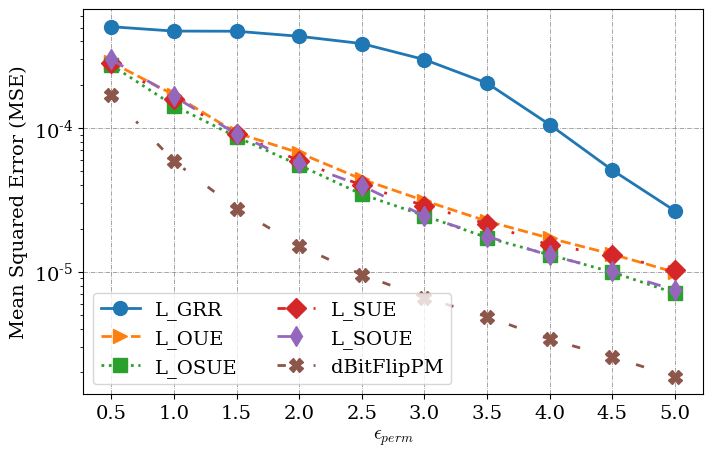

In [8]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_mse[seed]["L_GRR"] for seed in range(nb_seed)], axis=0), label='L_GRR', marker='o')
plt.plot(np.mean([dic_mse[seed]["L_OUE"] for seed in range(nb_seed)], axis=0), label='L_OUE',marker='>',linestyle='dashed')
plt.plot(np.mean([dic_mse[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0), label='L_OSUE',marker='s',linestyle='dotted')
plt.plot(np.mean([dic_mse[seed]["L_SUE"] for seed in range(nb_seed)], axis=0), label='L_SUE', marker='D', linestyle=(0, (3, 10, 1, 10)))
plt.plot(np.mean([dic_mse[seed]["L_SOUE"] for seed in range(nb_seed)], axis=0), label='L_SOUE',marker='d',linestyle=(0, (5, 10)))
plt.plot(np.mean([dic_mse[seed]["dBitFlipPM"] for seed in range(nb_seed)], axis=0), label='dBitFlipPM',marker='X',linestyle=(0, (3, 10, 1, 10)))

plt.yscale('log')
plt.xlabel('$\epsilon_{perm}$')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.legend(ncol=2)
plt.show()

## Example of Real vs Estimated Freqencies

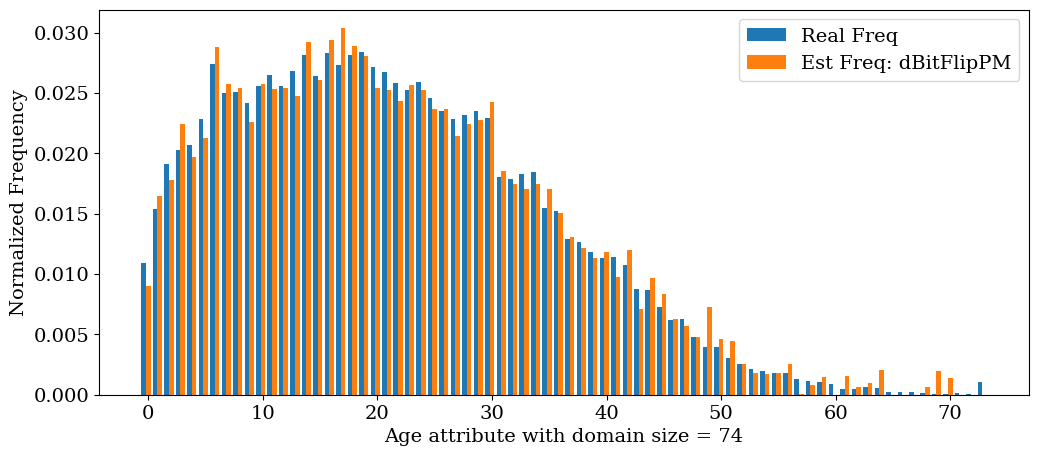

In [9]:
plt.figure(figsize=(12, 5))

barwidth = 0.4
x_axis = np.arange(k)

plt.bar(x_axis - barwidth, real_freq, label='Real Freq', width=barwidth)
plt.bar(x_axis, dbitflip_est_freq, label='Est Freq: dBitFlipPM', width=barwidth)
plt.ylabel('Normalized Frequency')
plt.xlabel('Age attribute with domain size = {}'.format(k))
plt.legend()
plt.show();